# Лабораторная работа № 2
### Боровских Вадим, 932003
## a) Регрессор, использующий слой RNN в качестве скрытого слоя
## b) Регрессор, ячейку LSTM (или GRU) в скрытом слое
## c) Регрессор – стек двух слоёв с LSTM (или GRU)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dropout

### Датасет содержит данные о погоде в Хабаровске


In [2]:
#открываем файл с данными и выводим на экран
df = pd.read_csv("KhabarWeather.csv", encoding='cp1251', sep=";", index_col = 0)
df

,T,P0,P,U,DD
LocalTime,,,,,
15.10.2020 23:30,4.0,753.6,760.5,48.0,Ветер
15.10.2020 23:00,4.0,753.6,760.5,48.0,Ветер
15.10.2020 22:30,5.0,753.6,760.5,42.0,Ветер
15.10.2020 22:00,5.0,753.6,760.5,42.0,Ветер
15.10.2020 21:30,5.0,753.6,760.5,45.0,Ветер
...,...,...,...,...,...
15.10.2012 03:00,2.0,750.0,756.9,100.0,Ветер
15.10.2012 02:30,3.0,750.0,756.9,93.0,Ветер
15.10.2012 02:00,3.0,749.3,756.2,100.0,Ветер


Значение столбцов:
* LocalTime - Дата и время 
* T - Температура в момент наблюдений
* Po - Атмосферное давление на уровне станции в момент наблюдений
* P - Атмосферное давление на уровне моря в момент наблюдений
* Pa - Атмосферное давление, приведенное к среднему уровню моря в момент наблюдений
* U - Относительная влажность воздуха в момент наблюдений
* DD - Наличие ветра в момент наблюдений

Признаки, используемые для анализа: "LocalTime" и "T"

In [3]:
df=df.reset_index() 
df

,LocalTime,T,P0,P,U,DD
0,15.10.2020 23:30,4.0,753.6,760.5,48.0,Ветер
1,15.10.2020 23:00,4.0,753.6,760.5,48.0,Ветер
2,15.10.2020 22:30,5.0,753.6,760.5,42.0,Ветер
3,15.10.2020 22:00,5.0,753.6,760.5,42.0,Ветер
4,15.10.2020 21:30,5.0,753.6,760.5,45.0,Ветер
...,...,...,...,...,...,...
119669,15.10.2012 03:00,2.0,750.0,756.9,100.0,Ветер
119670,15.10.2012 02:30,3.0,750.0,756.9,93.0,Ветер
119671,15.10.2012 02:00,3.0,749.3,756.2,100.0,Ветер
119672,15.10.2012 01:00,3.0,749.3,756.2,100.0,Ветер


In [4]:
#Описание данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119674 entries, 0 to 119673
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   LocalTime  119674 non-null  object 
 1   T          119665 non-null  float64
 2   P0         119664 non-null  float64
 3   P          119667 non-null  float64
 4   U          119665 non-null  float64
 5   DD         119662 non-null  object 
dtypes: float64(4), object(2)
memory usage: 5.5+ MB


Метод data.info() выводит информацию о данных: названия столбцов, количество ненулевых значений, тип данных и использование памяти. В данном датасете все столбцы числового типа данных(float), за исключением двух: "LocalTime" и "DD" - они содержат данные типа object

In [5]:
#Фильтруем и оставляем только два нужных столбца
df=df[['LocalTime','T']]

In [6]:
#Вычисляем количество пропущенных значений
df.isna().sum()

LocalTime    0
T            9
dtype: int64

In [7]:
#Удаляем пропущенные значения
df = df.dropna()

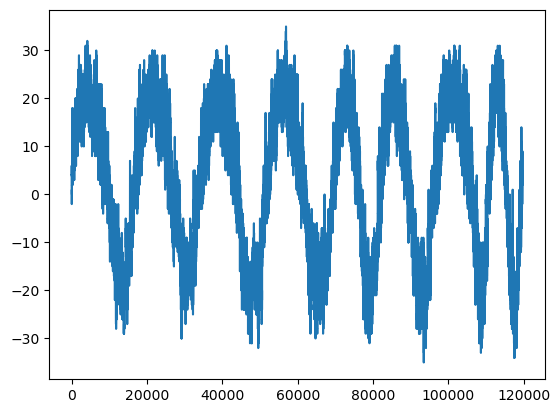

In [8]:
#Строим график значений температуры
plt.plot(range(1,len(df['T'].values)+1),df['T'].values)

In [9]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

data = df['T'].values
data = min_max_scaler.fit_transform(data.reshape(-1, 1))

In [10]:
#Преобразование массива
print(data.shape)
data =data.flatten()
print(data.shape)

(119665, 1)
(119665,)


In [11]:
#Раздеряем данные
window = 15

n_samples=data.shape[0]-window
n_train_samples=round(0.7*n_samples)
n_val_samples=round(0.15*n_samples)
n_test_samples=n_samples-n_train_samples-n_val_samples
print('Train = ',n_train_samples,'Validation = ',n_val_samples,'Test = ',n_test_samples)

Train =  83755 Validation =  17948 Test =  17947


In [12]:
#Создаём массивы для обучающей, валидационной и тестовой выборки
X_train=np.zeros((n_train_samples,window))
y_train=np.zeros(n_train_samples)

X_val=np.zeros((n_val_samples,window))
y_val=np.zeros(n_val_samples)

X_test=np.zeros((n_test_samples,window))
y_test=np.zeros(n_test_samples)

In [13]:
#Заполняем массивы
for i in range(n_train_samples):
  for j in range(window):
    X_train[i,j]=data[i+j]
  y_train[i]=data[i+window]

for i in range(n_val_samples):
  for j in range(window):
    X_val[i,j]=data[n_train_samples+i+j]
  y_val[i]=data[n_train_samples+i+window]

for i in range(n_test_samples):
  for j in range(window):
    X_test[i,j]=data[n_train_samples+n_val_samples+i+j]
  y_test[i]=data[n_train_samples+n_val_samples+i+window]

In [14]:
#Модель ff_model представляет собой нейронную сеть с одним скрытым слоем и одним выходным слоем
from keras.models import Sequential
from keras.layers import Dense

ff_model=Sequential()
ff_model.add(Dense(10,activation='relu',input_dim=window))
ff_model.add(Dropout(0.2))   # добавляем прореживание Dropout
ff_model.add(Dense(1))

In [15]:
#Выводим обзорную таблицу
ff_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                160       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 171 (684.00 Byte)
Trainable params: 171 (684.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
#Готовим модель к обучению
ff_model.compile(loss='mse',optimizer='adam',metrics='mae')

In [20]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

early_stop = EarlyStopping(monitor='val_mae',patience=5,mode='min',verbose=1)
checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_mae', verbose=1, save_best_only=True, mode='min')
callbacks_list=[early_stop,checkpoint]

In [23]:
#Обучаем модель
ff_model_history = ff_model.fit(X_train,y_train,batch_size=25,epochs=15,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/15
3343/3351 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0426
Epoch 1: val_mae did not improve from 0.02049
3351/3351 [==============================] - 19s 6ms/step - loss: 0.0044 - mae: 0.0426 - val_loss: 7.6924e-04 - val_mae: 0.0229
Epoch 2/15
3350/3351 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0429
Epoch 2: val_mae improved from 0.02049 to 0.01871, saving model to best_model_weights.h5
3351/3351 [==============================] - 19s 6ms/step - loss: 0.0045 - mae: 0.0429 - val_loss: 5.6827e-04 - val_mae: 0.0187
Epoch 3/15
3349/3351 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0428
Epoch 3: val_mae did not improve from 0.01871
3351/3351 [==============================] - 18s 5ms/step - loss: 0.0044 - mae: 0.0428 - val_loss: 7.9366e-04 - val_mae: 0.0233
Epoch 4/15
3341/3351 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0429
Epoch 4: val_mae did not improve from 0.01871
3351/3351 [======

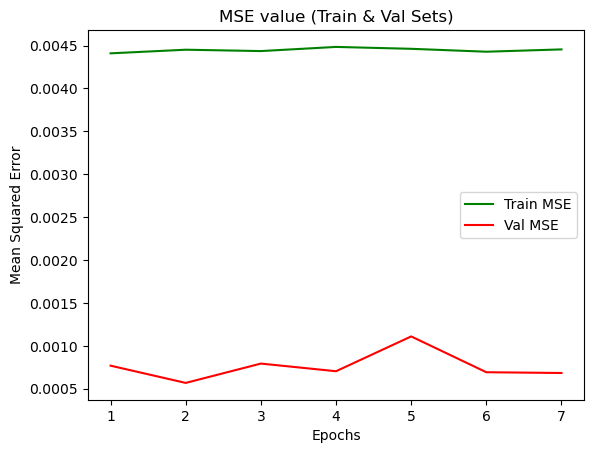

In [28]:
loss_function = ff_model_history.history['loss']
val_loss_function = ff_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('MSE value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train MSE')
plt.plot(epochs,val_loss_function,color='red',label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Вывод: 
* Train MSE идет почти ровно на 0.0045: Это указывает на то, что модель в процессе обучения минимизирует ошибку на тренировочном наборе данных и ошибка стабилизируется около 0.0045. Для нас это является приемлимы значением.
* Val MSE возрастает в диапазоне 0.0005 до 0.0010: Это означает, что ошибка на валидационном наборе данных растет с течением времени.

In [29]:
ff_model.load_weights('best_model_weights.h5')

In [30]:
from sklearn.metrics import mean_absolute_error,r2_score

y_pred = ff_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

561/561 [==============================] - 2s 4ms/step
MAE =  1.2  K degrees
R2-score =  0.99


Вывод: 
* R2 = 0.99: Значение 0.99 говорит о том, что около 99% дисперсии зависимой переменной может быть объяснено моделью. Это очень высокий показатель и указывает на то, что модель хорошо прогнозирует целевую переменную.
* MAE = 1.2: Значение MAE равное 1.2 указывает на то, что средняя абсолютная разница между предсказанными и фактическими значениями составляет 1.2 единицы. Чем ближе значение MAE к нулю, тем лучше модель прогнозирует данные.

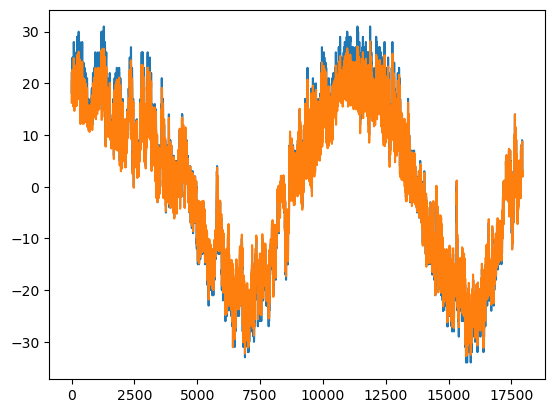

In [31]:
#Построение графиков
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
# FF-модель
y_pred_ff = ff_model.predict(X_test)
mse_ff = mean_squared_error(y_test, y_pred_ff)
print(f'MSE для FF-модели: {mse_ff}')

561/561 [==============================] - 2s 4ms/step
MSE для FF-модели: 0.0004938467663427029


Вывод: MSE (Средняя квадратичная ошибка) равная 0.00049 указывает на то, что прогнозы модели очень близки к истинным значениям. 

# Определяем простую рекуррентную модель (RNN)

In [34]:
from keras.layers import SimpleRNN

simple_rnn_model = Sequential()
simple_rnn_model.add(SimpleRNN(10,activation='relu',input_shape=(window,1)))
simple_rnn_model.add(Dropout(0.2))  # добавляем прореживание Dropout
simple_rnn_model.add(Dense(1,activation='linear'))

In [35]:
#Разделяем выборки на обучающую, тестовую и валидационную
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [36]:
simple_rnn_model.compile(loss='mse',optimizer='adam',metrics='mae')

In [37]:
early_stop = EarlyStopping(monitor='val_mae',patience=5,mode='min',verbose=1)
checkpoint = ModelCheckpoint('best_model.h5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

In [38]:
#Обучаем модель
simple_rnn_model_history = simple_rnn_model.fit(X_train,y_train,batch_size=25,epochs=15,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/15
3351/3351 [==============================] - ETA: 0s - loss: 0.0179 - mae: 0.0821
Epoch 1: val_mae improved from inf to 0.03007, saving model to best_model.h5
3351/3351 [==============================] - 35s 9ms/step - loss: 0.0179 - mae: 0.0821 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 2/15
  15/3351 [..............................] - ETA: 26s - loss: 0.0060 - mae: 0.0526

D:\Anaconda\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3349/3351 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0514
Epoch 2: val_mae improved from 0.03007 to 0.02504, saving model to best_model.h5
3351/3351 [==============================] - 30s 9ms/step - loss: 0.0056 - mae: 0.0514 - val_loss: 9.5636e-04 - val_mae: 0.0250
Epoch 3/15
3350/3351 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0506
Epoch 3: val_mae did not improve from 0.02504
3351/3351 [==============================] - 30s 9ms/step - loss: 0.0055 - mae: 0.0506 - val_loss: 0.0013 - val_mae: 0.0303
Epoch 4/15
3345/3351 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0499
Epoch 4: val_mae did not improve from 0.02504
3351/3351 [==============================] - 30s 9ms/step - loss: 0.0054 - mae: 0.0499 - val_loss: 0.0012 - val_mae: 0.0274
Epoch 5/15
3348/3351 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0493
Epoch 5: val_mae did not improve from 0.02504
3351/3351 [==============================] -

In [39]:
simple_rnn_model.load_weights('best_model.h5')

In [40]:
#Оцениваем прогнозирование
y_pred = simple_rnn_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

561/561 [==============================] - 3s 5ms/step
MAE =  1.378  K degrees
R2-score =  0.988


Выводы: 
* MAE = 1.378: Это означает, что в среднем абсолютное значение ошибки предсказаний составляет 1.378. То есть, в среднем предсказанные значения отклоняются от фактических значений на 1.378 единицы.
* R2 = 0.988: R2 = 0.988: Это высокое значение коэффициента детерминации (R2), которое указывает на то, что модель очень хорошо объясняет изменчивость зависимой переменной. Значение 0.988 означает, что примерно 98.8% дисперсии в данных может быть объяснено моделью

In [41]:
# SimpleRNN-модель
y_pred_rnn = simple_rnn_model.predict(X_test)
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
print(f'MSE для SimpleRNN-модели: {mse_rnn}')

561/561 [==============================] - 3s 5ms/step
MSE для SimpleRNN-модели: 0.0006218589133510601


Вывод: MSE около 0.000621. Это значит, что модель достаточно точно предсказывает значения целевой переменной на тестовой выборке. Чем ближе MSE к нулю, тем лучше модель справляется с задачей предсказания

# Определяем lSTM в скрытом слое

In [42]:

from keras.models import Sequential
from keras.layers import Dense,LSTM

model = Sequential()
model.add(LSTM(10,input_shape=(window,1)))
model.add(Dropout(0.2))  # добавляем прореживание Dropout
model.add(Dense(1,activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
model.compile(optimizer='adam',loss='mse',metrics='mae')

In [44]:
#Обучаем модель
history = model.fit(X_train,y_train,epochs=30,batch_size=32,
                    validation_data=(X_val,y_val))

Epoch 1/30
2618/2618 [==============================] - 44s 14ms/step - loss: 0.0167 - mae: 0.0776 - val_loss: 8.3180e-04 - val_mae: 0.0230
Epoch 2/30
2618/2618 [==============================] - 40s 15ms/step - loss: 0.0021 - mae: 0.0345 - val_loss: 4.9619e-04 - val_mae: 0.0169
Epoch 3/30
2618/2618 [==============================] - 40s 15ms/step - loss: 0.0014 - mae: 0.0280 - val_loss: 2.8762e-04 - val_mae: 0.0126
Epoch 4/30
2618/2618 [==============================] - 40s 15ms/step - loss: 0.0014 - mae: 0.0271 - val_loss: 2.3955e-04 - val_mae: 0.0116
Epoch 5/30
2618/2618 [==============================] - 41s 16ms/step - loss: 0.0013 - mae: 0.0266 - val_loss: 2.9562e-04 - val_mae: 0.0131
Epoch 6/30
2618/2618 [==============================] - 40s 15ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 1.9336e-04 - val_mae: 0.0102
Epoch 7/30
2618/2618 [==============================] - 41s 16ms/step - loss: 0.0013 - mae: 0.0261 - val_loss: 2.3673e-04 - val_mae: 0.0117
Epoch 8/30
2618/2618

In [45]:
y_pred = model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

561/561 [==============================] - 5s 6ms/step


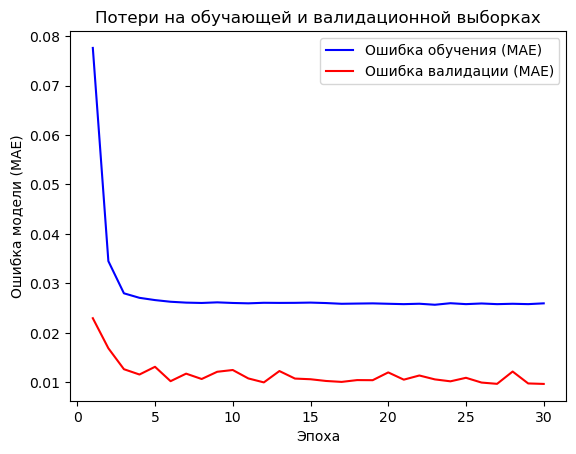

In [46]:
# Вычисляем метрику MAE
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('Потери на обучающей и валидационной выборках')
plt.plot(epochs,mae,color='blue',label='Ошибка обучения (MAE)')
plt.plot(epochs,val_mae,color='red',label='Ошибка валидации (MAE)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка модели (MAE)')
plt.legend()
plt.show()

Вывод: Кривые сначала снижались, а затем шли стабильно. Это говорит о том, что модель достаточно обучилась. Если бы кривые продолжали убывать, это говорило бы о недообучении, а при возрастании - о переобучении

In [47]:
#Оцениваем прогнозирование
y_pred = model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

from sklearn.metrics import r2_score,mean_absolute_error

print('R2 Score (Test) = ',round(r2_score(y_true=y_test_inv,y_pred=y_pred_inv),3))
print('MAE (Test) = ',round(mean_absolute_error(y_true=y_test_inv,
                                                     y_pred=y_pred_inv),3))

561/561 [==============================] - 4s 8ms/step
R2 Score (Test) =  0.996
MAE (Test) =  0.769


Вывод: 
* R2 = 0.996: Это очень высокое значение, которое показывает, что модель очень хорошо соответствует наблюдаемым данным.
* MAE = 0.769: Это означает, что в среднем прогнозы отклоняются от истинных значений всего на 0.769 градуса по Кельвину. Это довольно маленькое отклонение, особенно если учесть диапазон возможных значений температуры

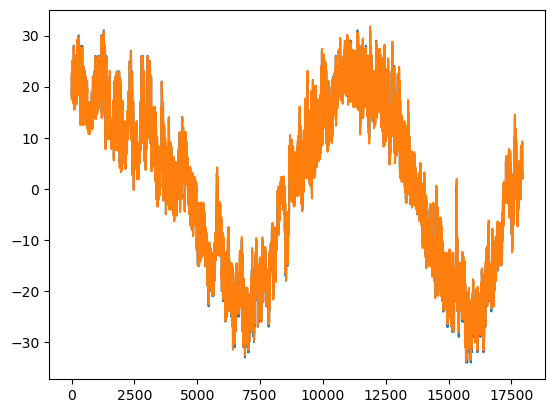

In [48]:
#Построение графиков
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)

In [49]:
# LSTM-модель
y_pred_lstm = model.predict(X_test)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print(f'MSE для LSTM-модели: {mse_lstm}')

561/561 [==============================] - 3s 6ms/step
MSE для LSTM-модели: 0.00022458404791200732


Вывод: MSE (Средняя квадратичная ошибка) около 0.000225. Это число говорит о том, как далеки прогнозы от истинных значений. Значение MSE близкое к нулю обычно свидетельствует о хорошей модели

# Определяем стек из двух слоев LSTM


In [50]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

stacked_lstm_model = Sequential()
stacked_lstm_model.add(LSTM(10, input_shape=(window,1), return_sequences=True)) # Первый слой LSTM
stacked_lstm_model.add(Dropout(0.2))  # Dropout после первого слоя LSTM
stacked_lstm_model.add(LSTM(10)) # Второй слой LSTM
stacked_lstm_model.add(Dropout(0.2))  # Dropout после второго слоя LSTM
stacked_lstm_model.add(Dense(1,activation='linear'))

stacked_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 15, 10)            480       
                                                                 
 dropout_3 (Dropout)         (None, 15, 10)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10)                840       
                                                                 
 dropout_4 (Dropout)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1331 (5.20 KB)
Trainable params: 1331 (5.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
#Обучаем модель
stacked_lstm_model.compile(optimizer='adam',loss='mse',metrics='mae')

history = stacked_lstm_model.fit(X_train,y_train,epochs=30,batch_size=32,
                                 validation_data=(X_val,y_val))

Epoch 1/30
2618/2618 [==============================] - 84s 28ms/step - loss: 0.0094 - mae: 0.0648 - val_loss: 0.0012 - val_mae: 0.0274
Epoch 2/30
2618/2618 [==============================] - 73s 28ms/step - loss: 0.0020 - mae: 0.0342 - val_loss: 5.1434e-04 - val_mae: 0.0171
Epoch 3/30
2618/2618 [==============================] - 71s 27ms/step - loss: 0.0017 - mae: 0.0303 - val_loss: 5.2486e-04 - val_mae: 0.0184
Epoch 4/30
2618/2618 [==============================] - 71s 27ms/step - loss: 0.0016 - mae: 0.0291 - val_loss: 3.7021e-04 - val_mae: 0.0147
Epoch 5/30
2618/2618 [==============================] - 70s 27ms/step - loss: 0.0015 - mae: 0.0287 - val_loss: 2.2302e-04 - val_mae: 0.0110
Epoch 6/30
2618/2618 [==============================] - 68s 26ms/step - loss: 0.0015 - mae: 0.0282 - val_loss: 3.1268e-04 - val_mae: 0.0138
Epoch 7/30
2618/2618 [==============================] - 69s 26ms/step - loss: 0.0015 - mae: 0.0280 - val_loss: 3.8339e-04 - val_mae: 0.0153
Epoch 8/30
2618/2618 [==

In [52]:
# Вычисление прогноза и обратное преобразование для получения температуры
y_pred = stacked_lstm_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

561/561 [==============================] - 7s 8ms/step


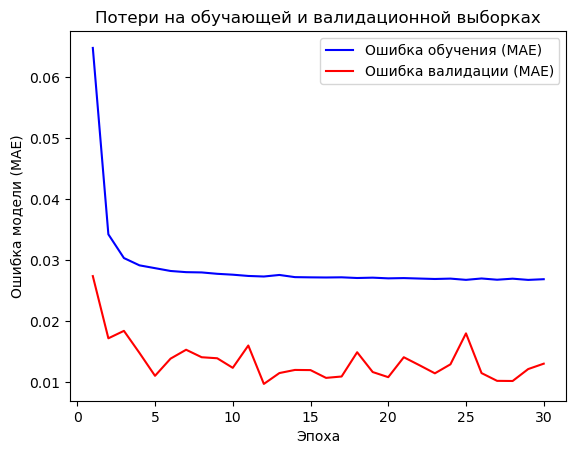

In [53]:
# Вывод значений ошибок 
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('Потери на обучающей и валидационной выборках')
plt.plot(epochs,mae,color='blue',label='Ошибка обучения (MAE)')
plt.plot(epochs,val_mae,color='red',label='Ошибка валидации (MAE)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка модели (MAE)')
plt.legend()
plt.show()

Вывод: Кривые сначала снижались, а затем шли стабильно. Это говорит о том, что модель достаточно обучилась. Если бы кривые продолжали убывать, это говорило бы о недообучении, а при возрастании - о переобучении

In [54]:
# Выведем на экран коэффициент детерминации и среднюю абсолютную ошибку
print('R2 Score (Test) = ',round(r2_score(y_true=y_test_inv,y_pred=y_pred_inv),3))
print('MAE (Test) = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3))

R2 Score (Test) =  0.993
MAE (Test) =  1.023


Вывод: 
* R2 = 0.993: Это очень высокое значение, которое показывает, что модель очень хорошо соответствует наблюдаемым данным.
* MAE = 1.023: Это означает, что в среднем прогнозы отклоняются от истинных значений всего на 1.023 градуса по Кельвину. Это довольно маленькое отклонение, особенно если учесть диапазон возможных значений температуры

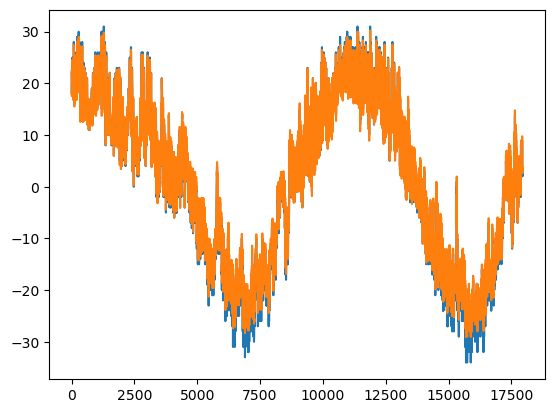

In [55]:
# График сравнения прогнозируемых и реальных значений температуры
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)

In [56]:
# Вычисляем MSE
y_pred = stacked_lstm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print('MSE:', mse)

561/561 [==============================] - 5s 9ms/step
MSE: 0.0003714062548094684


Вывод: MSE (Средняя квадратичная ошибка) около 0.00037. Это число говорит о том, как далеки прогнозы от истинных значений. Значение MSE близкое к нулю обычно свидетельствует о хорошей модели

### Вывод: 
Исходя из предоставленных результатов, можно сделать следующие выводы:

a) Регрессор, использующий слой RNN в качестве скрытого слоя, показывает хорошие результаты с MAE = 1.378 K degrees и R2-score = 0.988. Однако, MSE для данной модели составляет 0.0006218589133510601, что может указывать на тенденцию к небольшому разбросу в прогнозах.

b) Регрессор со слоем LSTM (или GRU) в скрытом слое имеет высокий R2 Score (Test) = 0.996 и низкое значение MAE (Test) = 0.769. MSE для LSTM-модели составляет 0.00022458404791200732, что указывает на более точные прогнозы по сравнению с моделью, использующей слой RNN.

c) Регрессор со стеком двух слоев LSTM (или GRU) также показывает хорошие результаты с R2 Score (Test) = 0.993 и MAE (Test) = 1.023. Однако, MSE для этой модели составляет 0.0003714062548094684, что немного выше, чем для модели с одним слоем LSTM.

Исходя из этих результатов, можно сделать вывод, что модель b), использующая слой LSTM (или GRU) в скрытом слое, демонстрирует лучшие результаты. Эта модель имеет самое высокое значение R2-score, наименьшую ошибку при предсказании (MAE) и наименьшую сумму квадратов ошибок (MSE). Модель с двумя слоями LSTM также показывает хорошие результаты, но имеет немного более высокое значение MSE.
